# Compare tensorflow VS librosa mel spectrogram

TLTR: tensorflow mel spec ~ librosa with htk=True, center=False and norm=None

In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

import librosa

from phaunos_ml.utils import tf_utils
from phaunos_ml.utils.feature_utils import AudioSegmentExtractor
import tensorflow as tf

tf.enable_eager_execution()

## Get some audio examples

In [2]:
TFRECORD_PATH = '/home/jul/data/xenocanto/custom_subsets/subset_1570008079/features/'
AUDIO_DIRNAME = 'audio/wav_22050hz_MLR'

In [3]:
# configure audio segment extractor
sr = 22050
segment_dur = 1
segment_hop_dur = 1
audio_ex = AudioSegmentExtractor(sr=sr, example_duration=segment_dur, example_hop_duration=segment_hop_dur)

In [4]:
# get some audio
example_filenames = random.sample(os.listdir(os.path.join(TFRECORD_PATH, 'positive', AUDIO_DIRNAME)), 2)

In [5]:
example_filenames

['XC303128.M.tf', 'XC296257.M.tf']

In [6]:
example1 = tf_utils.tfrecord2example(os.path.join(TFRECORD_PATH, 'positive', AUDIO_DIRNAME, example_filenames[0]), audio_ex)
example2 = tf_utils.tfrecord2example(os.path.join(TFRECORD_PATH, 'positive', AUDIO_DIRNAME, example_filenames[1]), audio_ex)

W1008 15:41:17.623421 140023774377792 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:44: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


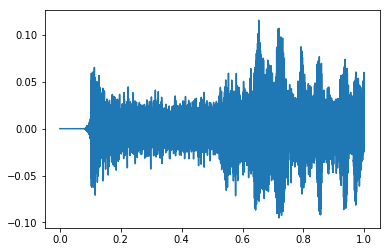

In [7]:
audio_ex.plot(example1[0]['data'][0])

## Compute mel spectrogram

In [8]:
# mel spectrogram parameters
n_fft = 512
hop_length = 128
min_freq = 50
max_freq = 8000
n_mels = 64

In [9]:
# tensorflow spectrogram
tf_spec = tf.abs(tf.contrib.signal.stft(
    example1[0]['data'][0],                                        
    frame_length=n_fft, 
    frame_step=hop_length,
    fft_length=n_fft))
tf_spec

W1008 15:41:18.466795 140023774377792 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



<tf.Tensor: id=531, shape=(169, 257), dtype=float32, numpy=
array([[2.6464171e-04, 1.8811497e-04, 1.3636478e-04, ..., 6.3197425e-05,
        1.1609933e-04, 9.3799274e-05],
       [5.4238575e-05, 1.6877292e-04, 1.6022675e-05, ..., 1.9021955e-04,
        1.1385175e-04, 3.6149133e-05],
       [1.4581998e-04, 1.5944647e-04, 1.1389059e-04, ..., 1.2682685e-04,
        9.5209238e-05, 1.3675322e-05],
       ...,
       [1.3035953e-02, 4.9464833e-02, 6.8648972e-02, ..., 1.1390694e-02,
        9.9420287e-03, 1.4467806e-02],
       [5.1756389e-03, 6.1162505e-02, 1.3055757e-01, ..., 6.7828023e-03,
        6.1729308e-03, 1.6753543e-02],
       [3.0534374e-02, 4.1511714e-02, 9.7258218e-02, ..., 4.6389168e-03,
        1.2345408e-02, 1.1670021e-02]], dtype=float32)>

In [10]:
# librosa spectrogram
lr_spec = np.abs(librosa.core.stft(example1[0]['data'][0].numpy(),                            
                            n_fft=n_fft,
                            hop_length=hop_length,
                            win_length=n_fft,
                            window='hann',
                            center=False,
                            pad_mode='reflect'))
lr_spec.T

array([[2.64641712e-04, 1.88114966e-04, 1.36364746e-04, ...,
        6.31974981e-05, 1.16099312e-04, 9.37992518e-05],
       [5.42385460e-05, 1.68772938e-04, 1.60226737e-05, ...,
        1.90219536e-04, 1.13851733e-04, 3.61491147e-05],
       [1.45819984e-04, 1.59446485e-04, 1.13890565e-04, ...,
        1.26826853e-04, 9.52092378e-05, 1.36753233e-05],
       ...,
       [1.30359875e-02, 4.94648889e-02, 6.86490014e-02, ...,
        1.13906758e-02, 9.94208641e-03, 1.44677693e-02],
       [5.17565059e-03, 6.11624606e-02, 1.30557537e-01, ...,
        6.78280462e-03, 6.17301837e-03, 1.67535227e-02],
       [3.05343717e-02, 4.15116251e-02, 9.72580984e-02, ...,
        4.63883160e-03, 1.23453792e-02, 1.16700111e-02]], dtype=float32)

In [11]:
# tensorflow mel filters
tf_mel_filters = tf.contrib.signal.linear_to_mel_weight_matrix(
    num_mel_bins=n_mels,
    num_spectrogram_bins=tf_spec.shape[-1].value,
    sample_rate=sr,
    lower_edge_hertz=min_freq,
    upper_edge_hertz=max_freq)
tf_mel_filters[90:120,50]

<tf.Tensor: id=673, shape=(30,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11720774,
       0.34630919, 0.5734516 , 0.79866946, 0.9780141 , 0.7565636 ,
       0.53694576, 0.31912607, 0.10308734, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)>

In [12]:
# librosa mel filters
lr_mel_filters = librosa.filters.mel(
    sr,
    n_fft,
    n_mels=n_mels,
    fmin=min_freq,
    fmax=max_freq,
    norm=None,
    htk=True)
lr_mel_filters.T[90:120,50]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11526588,
       0.34205323, 0.56884056, 0.7956279 , 0.97841424, 0.7600193 ,
       0.5416244 , 0.3232295 , 0.10483458, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [13]:
# tensorflow mel spectrogram
tf_mel_spec = tf.tensordot(tf_spec, tf_mel_filters, 1)
tf_mel_spec

<tf.Tensor: id=685, shape=(169, 64), dtype=float32, numpy=
array([[1.02570615e-04, 1.04488594e-04, 1.38611140e-04, ...,
        8.95370555e-04, 1.10179873e-03, 9.14163655e-04],
       [1.20519080e-05, 7.77587047e-05, 1.44676596e-04, ...,
        1.02275331e-03, 1.39708933e-03, 1.04585092e-03],
       [8.56660190e-05, 7.92205537e-05, 9.99882395e-05, ...,
        1.17146876e-03, 1.30457187e-03, 1.30824395e-03],
       ...,
       [5.16362637e-02, 6.12096190e-02, 8.66572335e-02, ...,
        5.41068673e-01, 7.92616427e-01, 9.49220955e-01],
       [9.82025638e-02, 8.11671466e-02, 9.57063511e-02, ...,
        9.77019489e-01, 8.06488514e-01, 7.08848536e-01],
       [7.31555149e-02, 3.91928777e-02, 2.95874216e-02, ...,
        6.75761640e-01, 5.68232715e-01, 5.02798498e-01]], dtype=float32)>

In [14]:
# librosa mel spectrogram
lr_mel_spec = np.dot(lr_mel_filters, lr_spec)
lr_mel_spec.T

array([[1.03048435e-04, 1.04895276e-04, 1.37726587e-04, ...,
        8.97810329e-04, 1.09969149e-03, 9.14360862e-04],
       [1.21080520e-05, 7.86257879e-05, 1.43753306e-04, ...,
        1.02504564e-03, 1.39678619e-03, 1.04457710e-03],
       [8.60650907e-05, 7.94595253e-05, 9.93501599e-05, ...,
        1.17381371e-03, 1.30546093e-03, 1.30599830e-03],
       ...,
       [5.18768393e-02, 6.15220815e-02, 8.61042514e-02, ...,
        5.41783452e-01, 7.93220401e-01, 9.48734641e-01],
       [9.86600295e-02, 8.13203901e-02, 9.50955972e-02, ...,
        9.77800965e-01, 8.05426717e-01, 7.08820105e-01],
       [7.34962299e-02, 3.90408523e-02, 2.93986127e-02, ...,
        6.76294744e-01, 5.67394674e-01, 5.03152728e-01]], dtype=float32)

In [15]:
# compute mel spectrogram directly with librosa
lr_mel_spec2 = librosa.feature.melspectrogram(
    y=example1[0]['data'][0].numpy(),
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=n_fft,
    n_mels=n_mels,
    htk=True,
    norm=None,
    fmin=min_freq,
    fmax=max_freq,
    window='hann',
    center=False,
    pad_mode='reflect',
    power=1.0)
lr_mel_spec2.T

array([[1.03048435e-04, 1.04895276e-04, 1.37726587e-04, ...,
        8.97810329e-04, 1.09969149e-03, 9.14360862e-04],
       [1.21080520e-05, 7.86257879e-05, 1.43753306e-04, ...,
        1.02504564e-03, 1.39678619e-03, 1.04457710e-03],
       [8.60650907e-05, 7.94595253e-05, 9.93501599e-05, ...,
        1.17381371e-03, 1.30546093e-03, 1.30599830e-03],
       ...,
       [5.18768393e-02, 6.15220815e-02, 8.61042514e-02, ...,
        5.41783452e-01, 7.93220401e-01, 9.48734641e-01],
       [9.86600295e-02, 8.13203901e-02, 9.50955972e-02, ...,
        9.77800965e-01, 8.05426717e-01, 7.08820105e-01],
       [7.34962299e-02, 3.90408523e-02, 2.93986127e-02, ...,
        6.76294744e-01, 5.67394674e-01, 5.03152728e-01]], dtype=float32)